This code is adapted from [Think Complexity by Alan Downey](http://greenteapress.com/complexity/) 

In [60]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from utils import decorate, savefig

from scipy.signal import correlate2d
from Cell2D import Cell2D, draw_array

from matplotlib.colors import LinearSegmentedColormap
import math


In [61]:
def locs_where(condition):
    """Find cells where a logical array is True.
    
    condition: logical array
    
    returns: list of location tuples
    """
    return list(zip(*np.nonzero(condition)))

In [126]:
# make a custom color map
palette = sns.color_palette('muted')
colors = 'white', palette[1], palette[0], 'black'
cmap = LinearSegmentedColormap.from_list('cmap', colors)


class Schelling(Cell2D):
    """Represents a grid of Schelling agents."""
    
    options = dict(mode='same', boundary='wrap')

    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.int8)
    
    def __init__(self, n, p_r, p_b, p_school, p_change, num_districts):
        """Initializes the attributes.

        n: number of rows
        p_w: threshold on the fraction of similar neighbors for red agents
        p_r: threshold on the fraction of similar neighbors for blue agents
        p_school: if a is the fraction of blue agents in the district, b is the fraction of red agents, p_school is the threshold for |a - b|
        p_change: if the agent likes their neighborhood, but is inclined to move districts, they will move with p_change probability
        """
        
        self.n = n
        
        self.p_r = p_r
        self.p_b = p_b
        self.p_school = p_school
        self.p_change = p_change
        
        self.num_districts = num_districts
        
        # 0 is empty, 1 is red, 2 is blue, 3 is school
        choices = np.array([0, 1, 2], dtype=np.int8)
        probs = [0.2, 0.4, 0.4]
        
        if num_districts == 4:
            left = np.random.choice(choices, (n, math.floor(n/2)), p = [0.2, 0.45, 0.35])
            right = np.random.choice(choices, (n, n - math.floor(n/2)), p = [0.2, 0.35, 0.45])
            self.array = np.zeros((n,n))
        
            self.array[:, 0:math.floor(n/2)] = left
            self.array[:, math.floor(n/2):] = right
            
        if num_districts == 9:
            left = np.random.choice(choices, (n, math.floor(n/3)), p = [0.2, 0.45, 0.35])
            middle = np.random.choice(choices, (n, math.floor(n/3)), p = [0.2, 0.4, 0.4])
            right = np.random.choice(choices, (n, n - 2*math.floor(n/3)), p = [0.2, 0.35, 0.45])
            self.array = np.zeros((n,n))
        
            self.array[:, 0:math.floor(n/3)] = left
            self.array[:, math.floor(n/3):math.floor(2*n/3)] = middle
            self.array[:, math.floor(2*n/3):] = right
            
        #add the schools, equally spaced throughout the grid
        
        if self.num_districts == 4:
            self.array[math.floor(n/4), math.floor(n/4)] = 3
            self.array[math.floor(n/4), math.floor(3*n/4)] = 3
            self.array[math.floor(3*n/4), math.floor(n/4)] = 3
            self.array[math.floor(3*n/4), math.floor(3*n/4)] = 3

        if self.num_districts == 9:
            self.array[math.floor(n/6), math.floor(n/6)] = 3
            self.array[math.floor(n/6), math.floor(n/2)] = 3
            self.array[math.floor(n/6), math.floor(5*n/6)] = 3

            self.array[math.floor(n/2), math.floor(n/6)] = 3
            self.array[math.floor(n/2), math.floor(n/2)] = 3
            self.array[math.floor(n/2), math.floor(5*n/6)] = 3

            self.array[math.floor(5*n/6), math.floor(n/6)] = 3
            self.array[math.floor(5*n/6), math.floor(n/2)] = 3
            self.array[math.floor(5*n/6), math.floor(5*n/6)] = 3
        
         # create an array where the value of each cell designates the district number of the cell
        self.district = np.zeros((self.n, self.n))
        
        divide_by = math.sqrt(self.num_districts)
        
        def interval(i):
            return math.floor(i*n/divide_by)

        #assign districts 
        index = 1
        for i in range(math.ceil(divide_by)):
            for j in range(math.ceil(divide_by)):
                self.district[interval(i): interval(i+1), interval(j): interval(j+1)] = index

                index = index + 1

        
    def count_neighbors(self):
        """Surveys neighboring cells.
        
        returns: tuple of
            empty: True where cells are empty
            school: True where there is a school
            frac_red: fraction of red neighbors around each cell
            frac_blue: fraction of blue neighbors around each cell
            frac_same: fraction of neighbors with the same color
        """
        a = self.array
        
        empty = a==0
        red = a==1
        blue = a==2
        school = a==3

        # count red neighbors, blue neighbors, and total
        num_red = correlate2d(red, self.kernel, **self.options)
        num_blue = correlate2d(blue, self.kernel, **self.options)
        num_neighbors = num_red + num_blue

        with np.errstate(invalid='ignore'):
            # compute fraction of similar neighbors
            frac_red = num_red / num_neighbors
            frac_blue = num_blue / num_neighbors

        # no neighbors is considered the same as no similar neighbors 
        # (this is an arbitrary choice for a rare event)
        frac_red[num_neighbors == 0] = 0
        frac_blue[num_neighbors == 0] = 0
        
        # for each cell, compute the fraction of neighbors with the same color
        frac_same = np.where(red, frac_red, frac_blue)

        # for empty cells, frac_same is NaN
        frac_same[empty] = np.nan
        frac_same[school] = np.nan
        
        return empty, school, frac_red, frac_blue, frac_same
    
    
    def count_district(self):
        """Surveys cells within the same school district.
        returns: tuple of
            empty: True where cells are empty
            school: True where there is a school
            frac_red: fraction of red agents in the school district as the cell
            frac_blue: fraction of blue agents in the school district as the cell
            frac_same: fraction of agents with the same color in the school district as the cell
        """
        
        a = self.array
        
        empty = a==0
        red = a==1
        blue = a==2
        school = a==3
        
        frac_red = np.zeros((self.n, self.n))
        frac_blue = np.zeros((self.n, self.n))
        
        # iterate over all 4 districts
        for dis_number in range(1,self.num_districts + 1):
            # get array of cells that are red in this district
            red_district = np.logical_and(red, self.district == dis_number)
            
            #count number of red agents in this district
            num_red = np.count_nonzero(red_district)
            
            # put number of red neighbors in this district in each cell
            num_red_array = np.where(self.district == dis_number, num_red, 0)
            
            # get array of cells that are blue in this district
            blue_district = np.logical_and(blue, self.district == dis_number)
            
            #count number of blue agents in this district
            num_blue = np.count_nonzero(blue_district)
            
            # put number of blue neighbors in this district in each cell
            num_blue_array = np.where(self.district == dis_number, num_blue, 0)
            
            num_total = num_red + num_blue
            
            frac_red += num_red_array/num_total
            frac_blue += num_blue_array/num_total
            
            #if there are no agents in the district, set frac to 0
            frac_red[num_total == 0] = 0
            frac_blue[num_total == 0] = 0
        
        frac_same = np.where(red, frac_red, frac_blue)

        # for empty cells, frac_same is NaN
        frac_same[empty] = np.nan
        frac_same[school] = np.nan
        
        return empty, school, frac_red, frac_blue, frac_same

    def segregation(self):
        """Computes the average fraction of similar neighbors.
        
        returns: fraction of similar neighbors, averaged over cells
        """
        _, _, _, _, frac_same_nbhd = self.count_neighbors()
        _, _, _, _, frac_same_district = self.count_district()
        return np.nanmean(frac_same_nbhd), np.nanmean(frac_same_district)
    
    def isolation(self, districts):
        """Computes the isolation wrt school districts"""
        
        isolate = 0
        
        isol_dist = np.zeros((self.n,self.n))
        
        divide_by = math.ceil(math.sqrt(districts))
        
        def interval(i):
            return math.floor(i*self.n/divide_by)

        #assign districts 
        index = 1
        for i in range(divide_by):
            for j in range(divide_by):
                isol_dist[interval(i): interval(i+1), interval(j): interval(j+1)] = index

                index = index + 1
        
        n_red = np.count_nonzero(np.array(self.array == 1))
                
        for i in range(1, districts + 1):
            red_dist = np.logical_and(isol_dist == i, self.array == 1)
            blue_dist = np.logical_and(isol_dist == i, self.array == 2)
            
            n_red_dist = np.count_nonzero(red_dist)
            n_blue_dist = np.count_nonzero(blue_dist)
            
            n_dist = n_red_dist + n_blue_dist
            
            isolate += (n_red_dist/n_red)*(n_blue_dist/n_dist)
            
        return isolate
            
    def dissimilarity(self, districts):
        """Computes the dissimilarity wrt school districts"""
        dissimilarity = 0
                
        diss_dist = np.zeros((self.n,self.n))
        
        divide_by = math.ceil(math.sqrt(districts))
        
        def interval(i):
            return math.floor(i*self.n/divide_by)

        #assign districts 
        index = 1
        for i in range(divide_by):
            for j in range(divide_by):
                diss_dist[interval(i): interval(i+1), interval(j): interval(j+1)] = index

                index = index + 1
        
        n_red = np.count_nonzero(np.array(self.array == 1))
        n_blue = np.count_nonzero(np.array(self.array == 2))
        
        for i in range(1, districts + 1):
            
            red_dist = np.logical_and(diss_dist == i, self.array == 1)
            blue_dist = np.logical_and(diss_dist == i, self.array == 2)
            
            n_red_dist = np.count_nonzero(red_dist)
            n_blue_dist = np.count_nonzero(blue_dist)
                        
            dissimilarity += abs((n_red_dist/n_red) - (n_blue_dist/n_blue))
            
        return dissimilarity/2
            
            
    def step(self):
        """Executes one time step.
                
        returns: fraction of similar neighbors, averaged over cells
        """
        def move_nbhd(empty, unhappy_nbhd, unhappy_district):
            # identify locations of cells that should move neighborhoods (stay in district)
            move_nbhd = np.logical_and(unhappy_nbhd, np.logical_not(unhappy_district))
            move_nbhd_locs = locs_where(move_nbhd)
            
            orig_district = [self.district[j] for j in move_nbhd_locs]
            
            # shuffle the unhappy cells
            if len(move_nbhd_locs):
                np.random.shuffle(move_nbhd_locs)
                
            for index in range(len(move_nbhd_locs)):
                source = move_nbhd_locs[index]

                # get the district number of the source location
                source_dis = orig_district[index]

                # empty spots in the original district
                dest_empty = np.logical_and(empty, np.isin(self.district, [source_dis]))
                    
                # find the locations of the empty cells
                empty_locs = locs_where(dest_empty)
                
                # for each unhappy district cell, choose a random destination (but need to make sure the destination is not in the same district)
                num_empty = np.sum(dest_empty)
                
                if num_empty == 0:
                    continue

                i = np.random.randint(num_empty)
                dest = empty_locs[i]

                # move
                a[dest] = a[source]
                a[source] = 0
                empty[source] = True
                empty[dest] = False
                

        def move_district(empty, unhappy_nbhd, unhappy_district):
            #identify locations of cells that should move districts
            
            poss_move = np.logical_and(np.logical_not(unhappy_nbhd), unhappy_district)
            
            poss_move_locs = locs_where(poss_move)
            
            n_poss_move = np.shape(poss_move_locs)[0]
                        
            change = np.random.choice([False, True], n_poss_move, p = [1 - self.p_change, self.p_change])
            
            for i in range(n_poss_move):
                poss_move[poss_move_locs[i][0]][poss_move_locs[i][1]] = change[i]
            
            move_district = np.logical_or(np.logical_and(unhappy_nbhd, unhappy_district), poss_move)
            
            #move_district = np.logical_and(np.logical_and(unhappy_nbhd, unhappy_district), poss_move)
            move_district_locs = locs_where(move_district)

            #get the district of origin of each agent that wants to move districts
            orig_district = [self.district[j] for j in move_district_locs]

            # shuffle the unhappy cells
            if len(move_district_locs):
                np.random.shuffle(move_district_locs)

            for index in range(len(move_district_locs)):
                source = move_district_locs[index]
                
                # get the district number of the source location
                source_dis = orig_district[index]
        
                # get array of possible districts to move to
                dest_dis = np.setdiff1d(range(1,self.num_districts + 1), [source_dis])

                # empty spots not in the original district
                dest_empty = np.logical_and(empty, np.isin(self.district, dest_dis))

                # find the locations of the empty cells
                empty_locs = locs_where(dest_empty)

                # for each unhappy district cell, choose a random destination (but need to make sure the destination is not in the same district)
                num_empty = np.sum(dest_empty)
                
                if num_empty == 0:
                    continue

                i = np.random.randint(num_empty)
                dest = empty_locs[i]

                # move
                a[dest] = a[source]
                a[source] = 0

                empty[source] = True
                empty[dest] = False
                
                
        a = self.array
                
        red = a==1
        blue = a==2
        
        empty, _, _, _, frac_same_nbhd = self.count_neighbors()
        _, _, frac_red_district, frac_blue_district, frac_same_district = self.count_district()
        
        # find the unhappy cells (ignore NaN in frac_same)
        with np.errstate(invalid='ignore'):
            # find cells unhappy with their neighborhood
            unhappy_nbhd = np.logical_or(np.logical_and(frac_same_nbhd < self.p_r, red), np.logical_and(frac_same_nbhd < self.p_b, blue))
            
            # find cells unhappy with their school district            
            unhappy_district = np.logical_or(np.logical_and(frac_red_district - frac_blue_district > self.p_school, red), np.logical_and(frac_blue_district - frac_red_district > self.p_school, blue))
            
            num_empty = np.sum(empty)
                        
            move_nbhd(empty, unhappy_nbhd, unhappy_district)
            
            move_district(empty, unhappy_nbhd, unhappy_district)

        # check that the number of empty cells is unchanged
        num_empty2 = np.sum(a==0)
        assert num_empty == num_empty2
        
        # return the average fraction of similar neighbors
        return [np.nanmean(frac_same_nbhd), np.nanmean(frac_same_district)]
       
    def draw(self):
        """Draws the cells."""
        return draw_array(self.array, cmap=cmap, vmax=3)

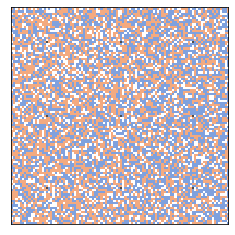

In [127]:
grid = Schelling(n=100, p_r = 0.5, p_b = 0.8, p_school = 0.10, p_change = 0.1, num_districts = 9)

grid.draw()

In [130]:
grid.isolation(36)

0.5040785348246798

In [131]:
grid.dissimilarity(36)

0.08721323042966245

In [132]:
for i in range(20):
    grid.step()

_, _, frac_red_district, frac_blue_district, _ = grid.count_district()
frac_red_district

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: divide by zero encountered in true_divide


array([[0.55316973, 0.55316973, 0.55316973, ..., 0.47066667, 0.47066667,
        0.47066667],
       [0.55316973, 0.55316973, 0.55316973, ..., 0.47066667, 0.47066667,
        0.47066667],
       [0.55316973, 0.55316973, 0.55316973, ..., 0.47066667, 0.47066667,
        0.47066667],
       ...,
       [0.48571429, 0.48571429, 0.48571429, ..., 0.44410876, 0.44410876,
        0.44410876],
       [0.48571429, 0.48571429, 0.48571429, ..., 0.44410876, 0.44410876,
        0.44410876],
       [0.48571429, 0.48571429, 0.48571429, ..., 0.44410876, 0.44410876,
        0.44410876]])

In [133]:
grid.isolation(36)

0.4712634377640559

In [134]:
grid.dissimilarity(36)

0.21548692349146376

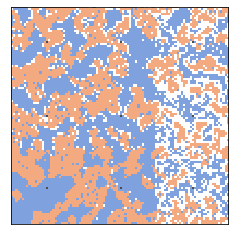

In [135]:
grid.draw()

In [120]:
frac_same_nbhd, _ = grid.segregation()
frac_same_nbhd

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: divide by zero encountered in true_divide


0.8913422204040978

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:134: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:135: RuntimeWarning: divide by zero encountered in true_divide


0.25 0.8943053419368558 0.6443053419368558
0.2 0.8938840519831632 0.6938840519831633
0.15 0.8927087099466057 0.7427087099466056
0.1 0.8972025028241306 0.7972025028241306
0.05 0.8766515675840824 0.8266515675840823


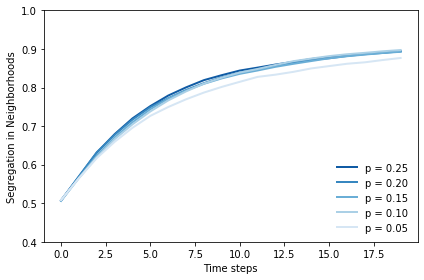

In [20]:
from utils import set_palette
set_palette('Blues', 5, reverse=True)

num_steps = 20
np.random.seed(17)
for p in [0.25, 0.2, 0.15, 0.1, 0.05]:
    seg_nbhd = np.zeros((num_steps))
    for n in range(20):
        grid = Schelling(n=100, p_r = 0.5, p_b = 0.75, p_school = p, p_change = 0.1, num_districts = 4)
        seg_nbhd += np.array([grid.step()[0] for i in range(num_steps)])

    seg_nbhd /= 20
    plt.plot(range(num_steps), seg_nbhd, label='p = %.2f' % p)
    print(p, seg_nbhd[-1], seg_nbhd[-1] - p)
    
decorate(xlabel='Time steps', ylabel='Segregation in Neighborhoods',
                loc='lower right', ylim=[0.4, 1])

In [ ]:
from utils import set_palette
set_palette('Blues', 5, reverse=True)

num_steps = 20
np.random.seed(17)
for p in [0.25, 0.2, 0.15, 0.1, 0.05]:
    seg_nbhd = np.zeros((num_steps))
    for n in range(20):
        grid = Schelling(n=100, p_r = 0.5, p_b = 0.75, p_school = p, p_change = 0.1, num_districts = 9)
        seg_nbhd += np.array([grid.step()[0] for i in range(num_steps)])

    seg_nbhd /= 20
    plt.plot(range(num_steps), seg_nbhd, label='p = %.2f' % p)
    print(p, seg_nbhd[-1], seg_nbhd[-1] - p)
    
decorate(xlabel='Time steps', ylabel='Segregation in Neighborhoods',
                loc='lower right', ylim=[0.4, 1])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:145: RuntimeWarning: divide by zero encountered in true_divide


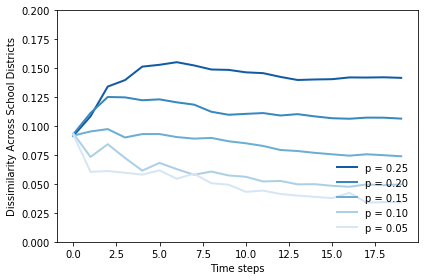

In [100]:
from utils import set_palette
set_palette('Blues', 5, reverse=True)

num_steps = 20
np.random.seed(17)
for p in [0.25, 0.2, 0.15, 0.1, 0.05]:
    dissimilarity = np.zeros((num_steps))
    for n in range(20):
        grid = Schelling(n=100, p_r = 0.5, p_b = 0.8, p_school = p, p_change = 0.1, num_districts = 9)
        for i in range(num_steps):
            dissimilarity[i] += grid.dissimilarity()
            grid.step()

    dissimilarity /= 20
    plt.plot(range(num_steps), dissimilarity, label='p = %.2f' % p)
    
decorate(xlabel='Time steps', ylabel='Dissimilarity Across School Districts',
                loc='lower right', ylim=[0, 0.2])

In [145]:
num_steps = 20
np.random.seed(17)

dissimilarity_4 = np.zeros((len(p_school), num_steps))
p_index = 0

for p in [0.25, 0.2, 0.15, 0.1, 0.05]:
    for n in range(20):
        grid = Schelling(n=100, p_r = 0.5, p_b = 0.8, p_school = p, p_change = 0.1, num_districts = 4)
        for i in range(num_steps):
            dissimilarity_4[p_index][i] += grid.dissimilarity(36)
            grid.step()
            
    dissimilarity_4[p_index] /= 20
    p_index = p_index + 1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: divide by zero encountered in true_divide


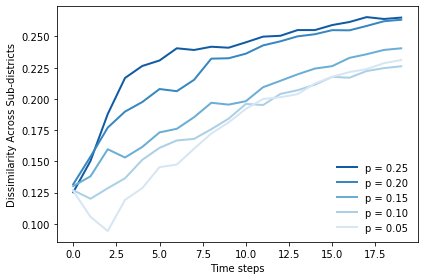

In [146]:
from utils import set_palette
set_palette('Blues', 5, reverse=True)

p_index = 0

for p in p_school:
    plt.plot(range(num_steps), dissimilarity_4[p_index], label='p = %.2f' % p)
    p_index = p_index + 1
    
decorate(xlabel='Time steps', ylabel='Dissimilarity Across Sub-districts',
                loc='lower right')

In [147]:
num_steps = 20
np.random.seed(17)

dissimilarity_9 = np.zeros((len(p_school), num_steps))
p_index = 0

for p in [0.25, 0.2, 0.15, 0.1, 0.05]:
    for n in range(20):
        grid = Schelling(n=100, p_r = 0.5, p_b = 0.8, p_school = p, p_change = 0.1, num_districts = 9)
        for i in range(num_steps):
            dissimilarity_9[p_index][i] += grid.dissimilarity(36)
            grid.step()
            
    dissimilarity_9[p_index] /= 20
    p_index = p_index + 1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: divide by zero encountered in true_divide


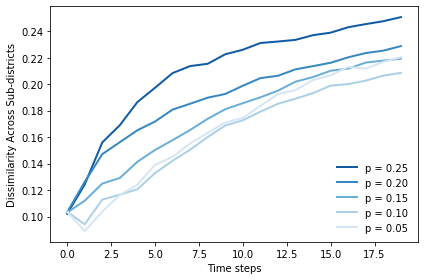

In [148]:
from utils import set_palette
set_palette('Blues', 5, reverse=True)

p_index = 0

for p in p_school:
    plt.plot(range(num_steps), dissimilarity_9[p_index], label='p = %.2f' % p)
    p_index = p_index + 1
    
decorate(xlabel='Time steps', ylabel='Dissimilarity Across Sub-districts',
                loc='lower right')

In [149]:
num_steps = 20
np.random.seed(17)
p_school = [0.25, 0.2, 0.15, 0.1, 0.05]
isolation_4 = np.zeros((len(p_school), num_steps))
p_index = 0

for p in p_school:
    for n in range(20):
        grid = Schelling(n=100, p_r = 0.5, p_b = 0.8, p_school = p, p_change = 0.1, num_districts = 4)
        for i in range(num_steps):
            isolation_4[p_index][i] += grid.isolation(36)
            grid.step()
                    
    isolation_4[p_index] /= 20
    p_index = p_index + 1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: divide by zero encountered in true_divide


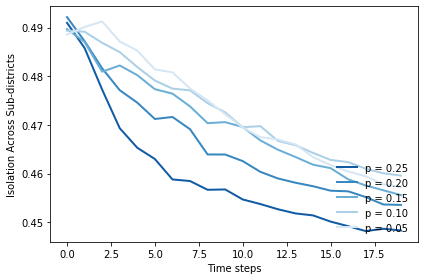

In [150]:
from utils import set_palette
set_palette('Blues', 5, reverse=True)

p_index = 0

for p in p_school:
    plt.plot(range(num_steps), isolation_4[p_index], label='p = %.2f' % p)
    p_index = p_index + 1
    
decorate(xlabel='Time steps', ylabel='Isolation Across Sub-districts',
                loc='lower right')

In [151]:
num_steps = 20
np.random.seed(17)
p_school = [0.25, 0.2, 0.15, 0.1, 0.05]
isolation_9 = np.zeros((len(p_school), num_steps))
p_index = 0

for p in p_school:
    for n in range(20):
        grid = Schelling(n=100, p_r = 0.5, p_b = 0.8, p_school = p, p_change = 0.1, num_districts = 9)
        for i in range(num_steps):
            isolation_9[p_index][i] += grid.isolation(36)
            grid.step()
                    
    isolation_9[p_index] /= 20
    p_index = p_index + 1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: divide by zero encountered in true_divide


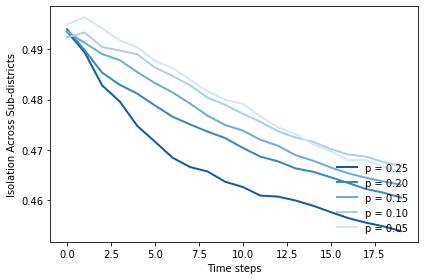

In [152]:
from utils import set_palette
set_palette('Blues', 5, reverse=True)

p_index = 0

for p in p_school:
    plt.plot(range(num_steps), isolation_9[p_index], label='p = %.2f' % p)
    p_index = p_index + 1
    
decorate(xlabel='Time steps', ylabel='Isolation Across Sub-districts',
                loc='lower right')